In [65]:
import backtrader as bt
import yfinance as yf
from datetime import datetime
import numpy as np

from sklearn.linear_model import LinearRegression



In [83]:
df = yf.download('AAPL', start='2010-01-01').to_csv('AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


## LinearRegressionStrategy 1

In [68]:
class LinearRegressionStrategy(bt.Strategy):
    params = (
        ('lookback_period', 100),
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.lr_model = LinearRegression()
        self.recent_prices = np.array([])

    def next(self):
        if len(self.recent_prices) < self.params.lookback_period:
            self.recent_prices = np.append(self.recent_prices, [self.data_close[0]])
            return

        # Prepare the data for linear regression
        X = np.arange(1, self.params.lookback_period+1).reshape(-1, 1)
        y = self.recent_prices.reshape(-1, 1)

        # Fit linear regression model
        self.lr_model.fit(X, y)

        # Predict next price
        next_price = self.lr_model.predict([[self.params.lookback_period + 1]])[0][0]

        if self.data_close[0] < next_price:
            if not self.position:
                self.buy(size=1)  # Buy one lot
                print(f'Buy | Current price: {self.data_close[0]}, next predicted price: {next_price}')

        elif self.position and self.data_close[0] > next_price:
            self.sell(size=1)  # Sell before buying a new one
            print(f'Sell | Current price: {self.data_close[0]}, next predicted price: {next_price}')
        else:
            print(f'Hold | Current price: {self.data_close[0]}, next predicted price: {next_price}')

        # Update recent prices
        self.recent_prices = np.roll(self.recent_prices, -1)
        self.recent_prices[-1] = self.data_close[0]

data = bt.feeds.YahooFinanceData(dataname='AAPL.csv', fromdate=datetime(2020, 1, 1))

# Initialize backtest
cerebro = bt.Cerebro()
cerebro.adddata(data)

# Add strategy
cerebro.addstrategy(LinearRegressionStrategy)


# Set initial cash
cerebro.broker.setcash(10000)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
cerebro.run()

# Print final portfolio value
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 10000.00
Hold | Current price: 77.67, next predicted price: 67.92483030303029
Hold | Current price: 77.7, next predicted price: 68.22662424242425
Hold | Current price: 77.63, next predicted price: 68.51213333333332
Hold | Current price: 78.58, next predicted price: 68.80349090909093
Hold | Current price: 78.94, next predicted price: 69.12272727272726
Hold | Current price: 79.38, next predicted price: 69.47677575757577
Hold | Current price: 78.7, next predicted price: 69.87736363636363
Hold | Current price: 80.94, next predicted price: 70.25172727272727
Hold | Current price: 81.42, next predicted price: 70.7470606060606
Hold | Current price: 83.99, next predicted price: 71.23777575757575
Hold | Current price: 86.15, next predicted price: 71.82118181818181
Hold | Current price: 82.01, next predicted price: 72.50549696969695
Hold | Current price: 82.72, next predicted price: 73.03592727272728
Hold | Current price: 83.74, next predicted price: 73.5810606060606
Hol

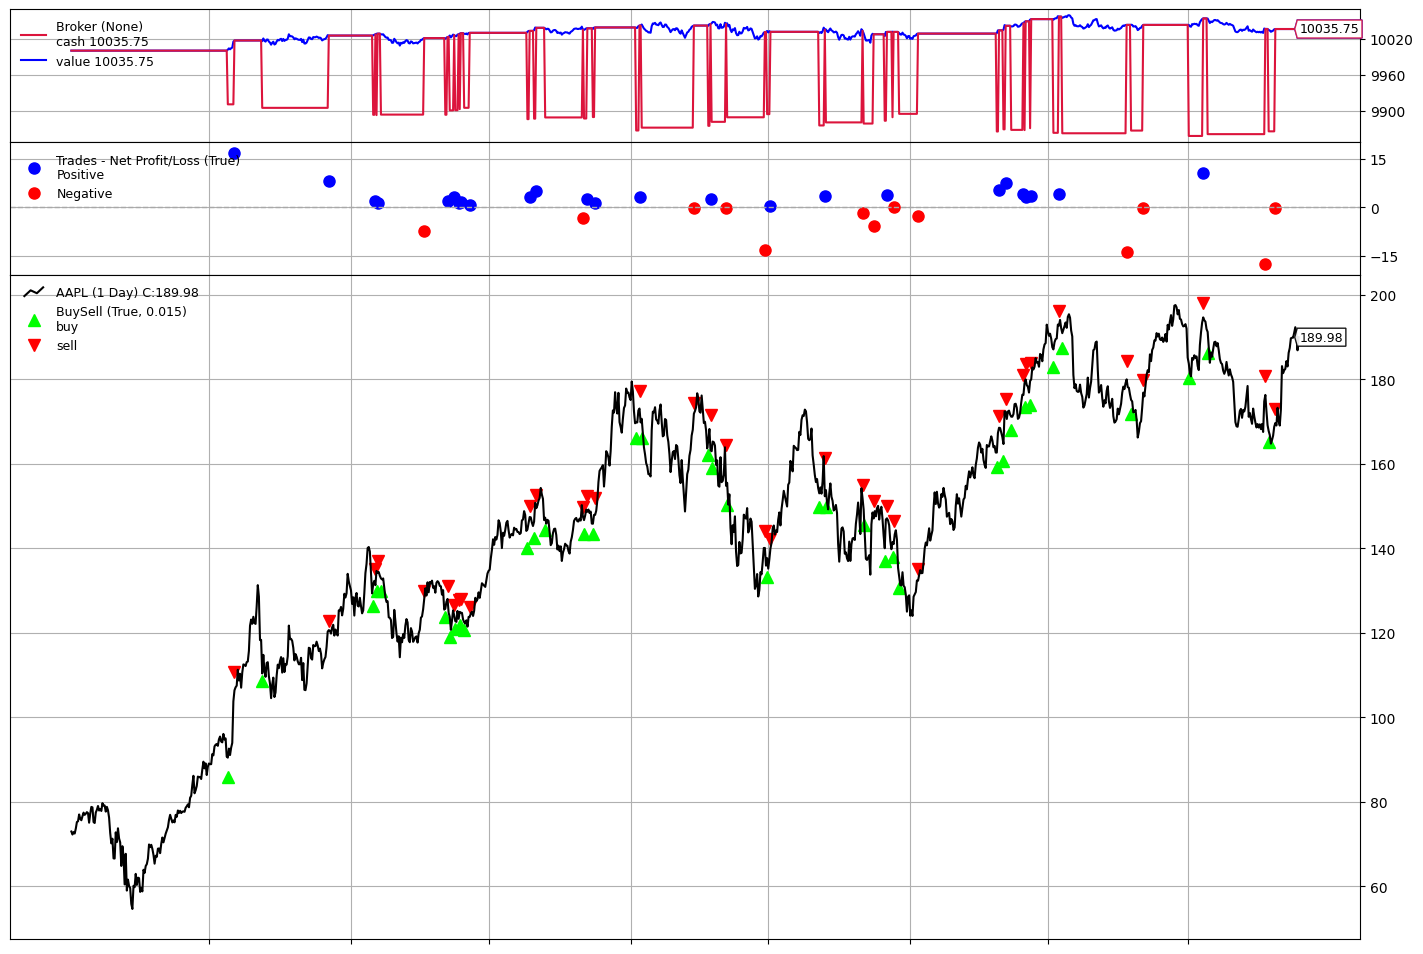

[[<Figure size 1500x1000 with 3 Axes>]]

In [69]:
%matplotlib inline
# increase the size of the plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

cerebro.plot(iplot=False, volume=False)

## LinearRegressionStrategy 2

### Predict further ahead

In [86]:
import backtrader as bt
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression

class LinearRegressionStrategy(bt.Strategy):
    params = (
        ('lookback_period', 200),
        ('predict_ahead', 30),  # Predict 5 candles ahead
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.regression_model = LinearRegression()
        self.predicted_prices = []

    def next(self):
        if len(self.data) > self.params.lookback_period + self.params.predict_ahead:
            X = np.arange(0, self.params.lookback_period).reshape(-1, 1)
            y = np.array(self.data_close.get(size=self.params.lookback_period))

            self.regression_model.fit(X, y)
            predicted_price = self.regression_model.predict([[self.params.lookback_period + self.params.predict_ahead]])[0]
            self.predicted_prices.append(predicted_price)

            if not self.position:  # If not already in a position
                if self.data_close[0] < predicted_price:
                    self.buy(size=1)  # Buy one lot
                    print(f'Buy | {len(self)} | Current price: {self.data_close[0]}, future predicted price: {predicted_price}')

            elif self.data_close[0] > predicted_price:
                self.sell(size=1)  # Sell one lot
                print(f'Sell | {len(self)} | Current price: {self.data_close[0]}, future predicted price: {predicted_price}')


    def stop(self):
        # Convert predicted prices to numpy array
        self.predicted_prices = np.array(self.predicted_prices)

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a data feed
data = bt.feeds.YahooFinanceData(dataname='AAPL.csv', fromdate=datetime(2016, 1, 1))
cerebro.adddata(data)

# Add the strategy
cerebro.addstrategy(LinearRegressionStrategy)

# Set our desired cash start
cerebro.broker.set_cash(300)

# Set the commission
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 300.00
Buy | 231 | Current price: 25.65, future predicted price: 26.59553189829746
Sell | 240 | Current price: 26.73, future predicted price: 26.705133623340586
Buy | 241 | Current price: 26.73, future predicted price: 26.747414257856445
Sell | 242 | Current price: 26.88, future predicted price: 26.79527561689042
Buy | 247 | Current price: 26.99, future predicted price: 27.04699929498237
Sell | 249 | Current price: 27.21, future predicted price: 27.150860286507168
Buy | 250 | Current price: 27.09, future predicted price: 27.208162776569424
Sell | 259 | Current price: 27.79, future predicted price: 27.780483889597246
Buy | 260 | Current price: 27.67, future predicted price: 27.86273072076802
Sell | 273 | Current price: 29.88, future predicted price: 29.046116410410264
Buy | 306 | Current price: 32.59, future predicted price: 32.59357160429011
Sell | 307 | Current price: 32.96, future predicted price: 32.7008774919373
Buy | 309 | Current price: 32.78, future pre

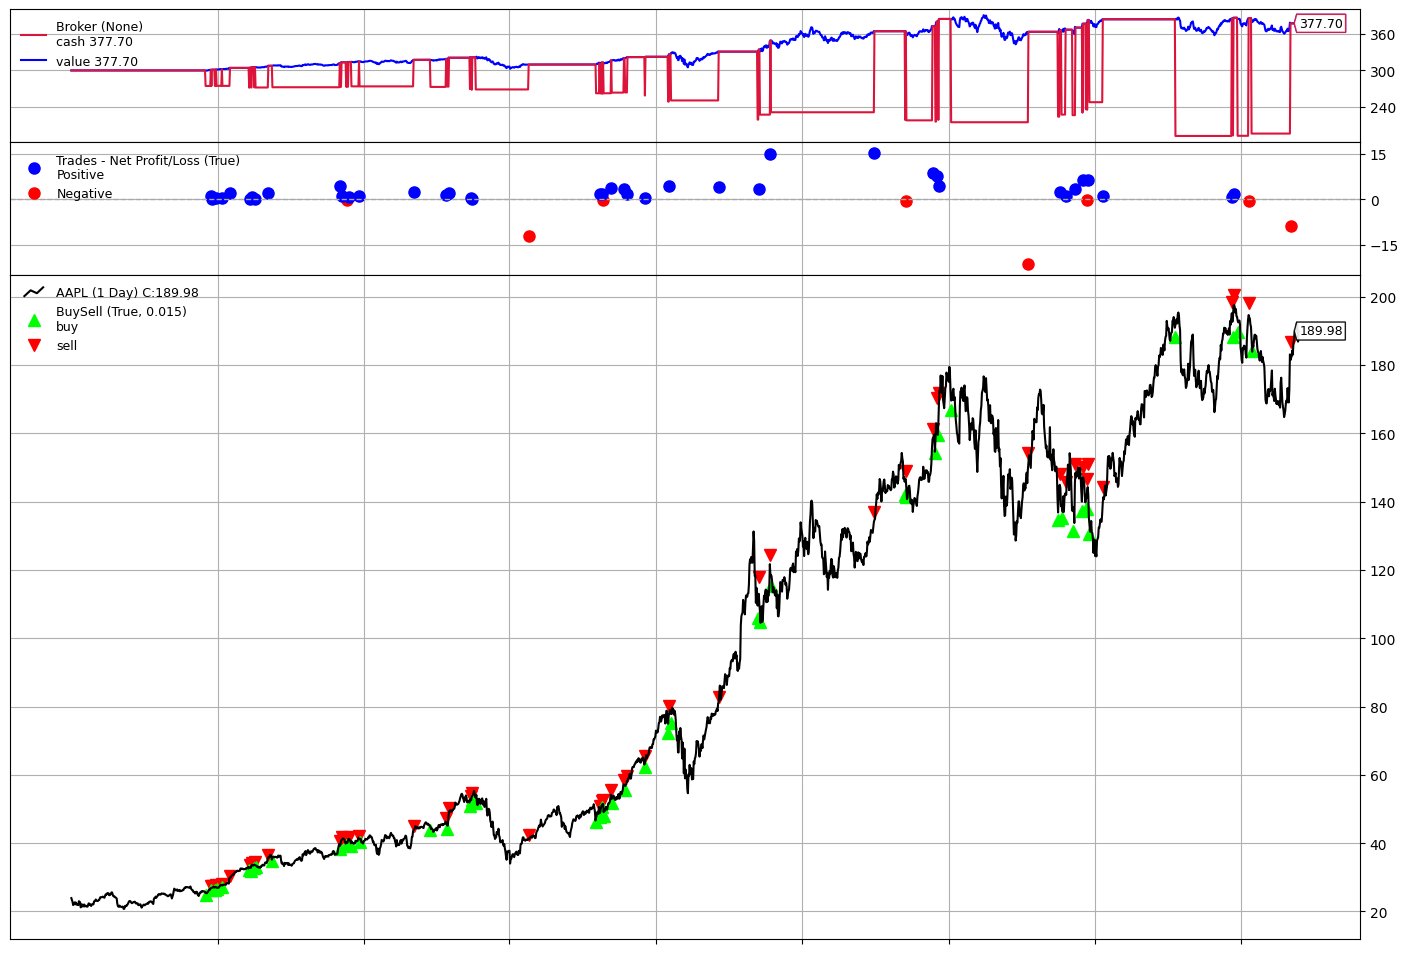

[[<Figure size 1500x1000 with 3 Axes>]]

In [87]:
%matplotlib inline
# increase the size of the plot
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

cerebro.plot(iplot=False, volume=False)